## Import Modules

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BASE_DIR = "/content/drive/My Drive/Colab Notebooks/dataset/flickr30k_images/"

IMG_DIR = os.path.join(BASE_DIR, 'images')
CAPTIONS_FILE = os.path.join(BASE_DIR, 'results.csv')

In [6]:
#!ls "/content/drive/My Drive/Colab Notebooks/dataset/flickr30k_images/images/"


## Extract Image Features

In [7]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())


# Load VGG16 model (pre-trained on ImageNet)
#model = VGG16(include_top=False, pooling='avg')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
IMG_DIR = '/content/drive/My Drive/Colab Notebooks/dataset/flickr30k_images/images/'

features = {}

for img_name in tqdm(os.listdir(IMG_DIR)):
    # Check if the file is an image (you can customize the extensions)
    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
        continue  # Skip non-image files

    # load the image from file
    img_path = os.path.join(IMG_DIR, img_name)

    try:
        image = load_img(img_path, target_size=(224, 224))
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue  # Skip to the next image if there's an error

    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for VGG
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/484 [00:00<?, ?it/s]

In [9]:
# Store features in pickle
WORKING_DIR = '/content/drive/My Drive/Colab Notebooks'
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

## Load the Captions Data

In [10]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the captions, try a different delimiter (e.g., tab)
captions_df = pd.read_csv(CAPTIONS_FILE, delimiter='\t')

# Print first few rows to check if it loaded correctly
print(captions_df.head())


                 image_name| comment_number| comment
0  1000092795.jpg| 0| Two young guys with shaggy ...
1  1000092795.jpg| 1| Two young , White males are...
2  1000092795.jpg| 2| Two men in green shirts are...
3  1000092795.jpg| 3| A man in a blue shirt stand...
4  1000092795.jpg| 4| Two friends enjoy time spen...


In [11]:
import csv # Import the csv module

# Create mapping of image to captions
mapping = {}

# Open the captions file
with open(CAPTIONS_FILE, 'r') as file:
    reader = csv.reader(file, delimiter=',')  # Adjust the delimiter if necessary
    for row in tqdm(reader):
        if len(row) < 2:
            continue
        image_id, caption = row[0], row[1:]
        image_id = image_id.split('.')[0]
        caption = " ".join(caption)
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)

# Print a sample to verify
print(list(mapping.items())[:5])

0it [00:00, ?it/s]

[('1000092795', [' White males are outside near many bushes .']), ('1000366164', [' one in a gray shirt   one in a black shirt   standing near a stove .']), ('10010052', [' holding a cellular phone to her ear .']), ('1001545525', [' at night .']), ('1001896054', [' while the driver wears easy to see clothing .'])]


In [12]:
len(mapping)

12955

## Preprocess Text Data

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
print(mapping.keys())

dict_keys(['1000092795', '1000366164', '10010052', '1001545525', '1001896054', '1003420127', '1003428081', '1006452823', '100716317', '1010031975', '10101477', '1010470346', '101093045', '1012212859', '101262930', '1013536888', '1014785440', '101559400', '10160966', '1017675163', '1021332107', '1021439420', '1021442086', '1022454332', '1022454428', '102520526', '102617084', '1027211271', '102851549', '10287332', '1028982826', '1029802110', '102998070', '1030041880', '103106960', '1031973097', '103205630', '1035392784', '1042590306', '1043819504', '1043910339', '1045124251', '104669470', '1047921035', '104816788', '104824673', '104835889', '1049955899', '105077209', '1051205546', '1051290485', '1051953669', '1053116826', '1053243591', '105342180', '1054620089', '105493628', '1056249424', '1056338697', '1056415186', '105685221', '105806535', '1059514525', '10602072', '106039369', '1061467336', '1061887159', '106300392', '106356264', '106372282', '106959209', '107022557', '1072439304', '1

In [15]:
# before preprocess of text
mapping['1000092795']

[' White males are outside near many bushes .']

In [16]:
# preprocess the text
clean(mapping)

In [17]:
# after preprocess of text
mapping['997338199']

['startseq decorated walls endseq']

In [18]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

17064

In [20]:
all_captions[:10]

['startseq white males are outside near many bushes endseq',
 'startseq one in gray shirt one in black shirt standing near stove endseq',
 'startseq holding cellular phone to her ear endseq',
 'startseq at night endseq',
 'startseq while the driver wears easy to see clothing endseq',
 'startseq inside home sitting on chairs arranged in circle playing type of musical instruments endseq',
 'startseq man and four women practicing sheet music (using flutes in living room endseq',
 'startseq some holding musical instruments endseq',
 'startseq both wearing glasses are playing clarinets and an elderly woman is playing stringed instrument endseq',
 'startseq three of which are clearly playing musical instrument endseq']

In [21]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)

In [23]:
vocab_size

7972

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

71

## Train Test Split

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [27]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

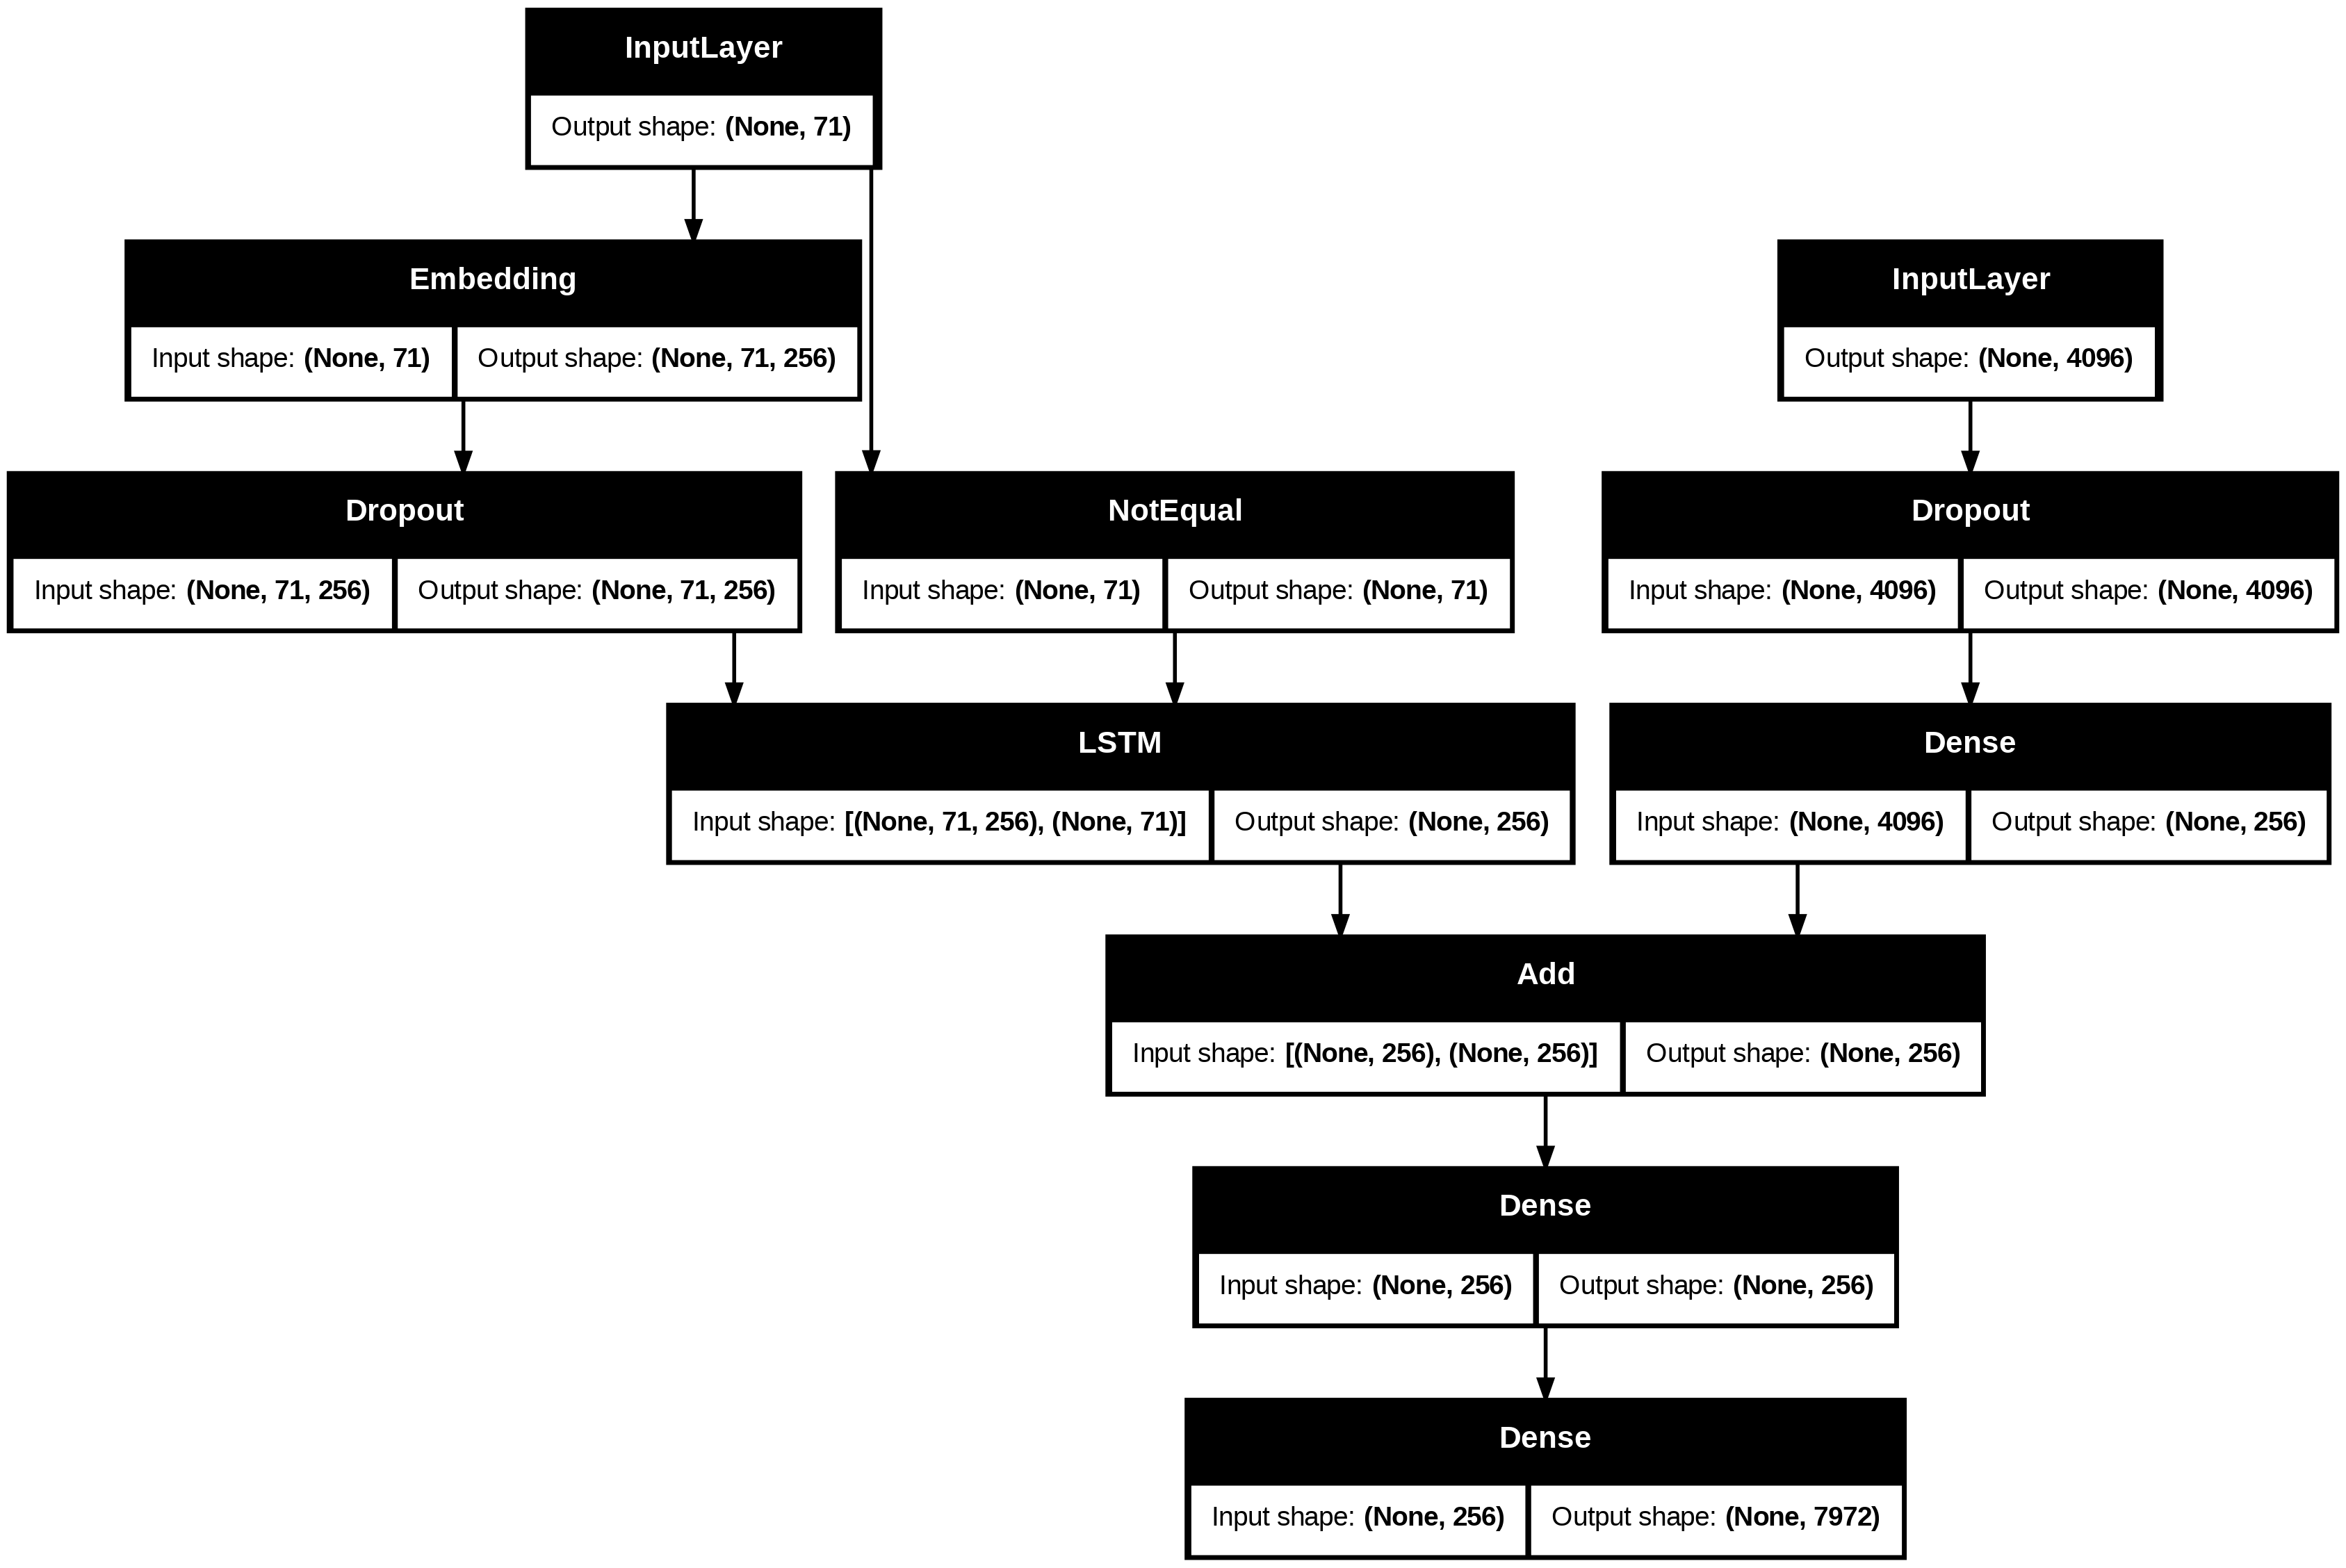

In [28]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# Disable cuDNN by setting use_cudnn to False in LSTM layer
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [29]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            # Check if the key exists in features before accessing it.
            if key in features:
                n += 1
                captions = mapping[key]
                # process each caption
                for caption in captions:
                    # encode the sequence
                    seq = tokenizer.texts_to_sequences([caption])[0]
                    # split the sequence into X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pairs
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        # store the sequences
                        X1.append(features[key][0])
                        X2.append(in_seq)
                        y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [43]:
# train the model
epochs = 25
batch_size = 70
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0409
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.0414
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - loss: 0.0416
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0408
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0408
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0407
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0423
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0503
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0406
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0406
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0402
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0402
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0401
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0418
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.0436
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - loss: 0.0409
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0399
166/166 ━━━━━━

In [44]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [45]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [46]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    # Remove 'startseq' and 'endseq' from the final caption
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

In [47]:
from nltk.translate.bleu_score import corpus_bleu
import nltk # Import the nltk module

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Check if the key exists in features before accessing it
    if key in features:
        # get actual caption
        captions = mapping[key]
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        # split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)
    else:
        print(f"Key '{key}' not found in features. Skipping.")

# Handle the potential ZeroDivisionError
# Use smoothing to avoid division by zero
smoothing_function = nltk.translate.bleu_score.SmoothingFunction().method1
# Check if actual and predicted have any elements before calculating BLEU scores
if actual and predicted:
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothing_function))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function))
else:
    print("Warning: Either actual or predicted captions are empty. Cannot calculate BLEU score.")

  0%|          | 0/1296 [00:00<?, ?it/s]

Key '6886763182' not found in features. Skipping.
Key '6887014469' not found in features. Skipping.
Key '6887014829' not found in features. Skipping.
Key '6887015039' not found in features. Skipping.
Key '6887015851' not found in features. Skipping.
Key '6887324285' not found in features. Skipping.
Key '6887588466' not found in features. Skipping.
Key '6888161449' not found in features. Skipping.
Key '6888801884' not found in features. Skipping.
Key '688926797' not found in features. Skipping.
Key '68897277' not found in features. Skipping.
Key '6891631263' not found in features. Skipping.
Key '689172411' not found in features. Skipping.
Key '6891956806' not found in features. Skipping.
Key '6892090337' not found in features. Skipping.
Key '6892893152' not found in features. Skipping.
Key '6893981593' not found in features. Skipping.
Key '6894721598' not found in features. Skipping.
Key '6894728048' not found in features. Skipping.
Key '6895479523' not found in features. Skipping.
Key 

## Visualize the Results

In [51]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq white males are outside near many bushes endseq
--------------------Predicted--------------------
white males are outside near many bushes


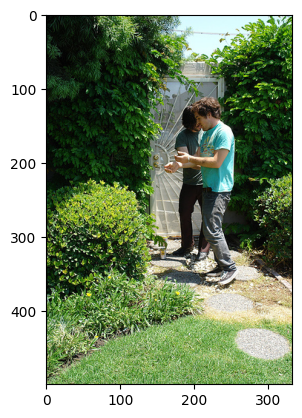

In [52]:
generate_caption("1000092795.jpg")

---------------------Actual---------------------
startseq holding broom with traditional asian architecture in the background endseq
--------------------Predicted--------------------
holding broom with traditional asian architecture in the background


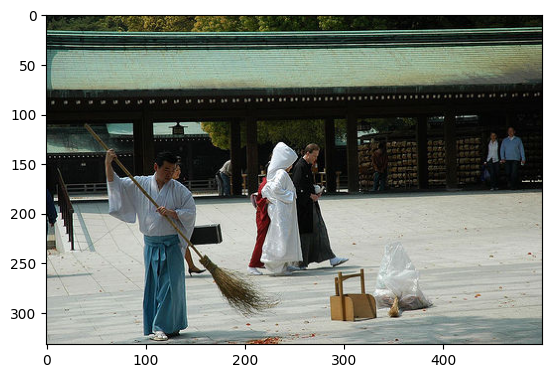

In [53]:
generate_caption("10101477.jpg")

---------------------Actual---------------------
startseq holding cellular phone to her ear endseq
--------------------Predicted--------------------
holding cellular phone to her ear


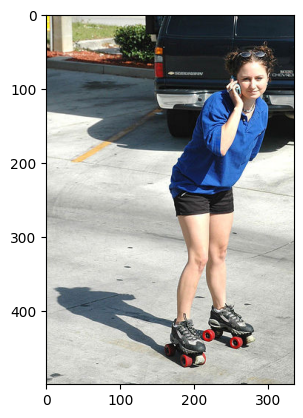

In [54]:
generate_caption("10010052.jpg")

In [55]:
!pip install gTTS

In [56]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [59]:
IMG_DIR = '/content/Black Luxury_ Living the Lavish Life of Success.jpeg'

# load image
image = load_img(IMG_DIR, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
caption = predict_caption(model, feature, tokenizer, max_length)
print(caption)

while man in dreadlocks and the woods putting cool green feet


In [58]:
from gtts import gTTS
from IPython.display import Audio


tts = gTTS(text=caption, lang='en')
tts.save("caption.mp3")

# Play the audio in the notebook
Audio("caption.mp3", autoplay=False)